# 💾 📊 Fund Data - Ranking and returns 📊 💾

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
import numpy as np
from scipy import stats


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
myCSVfile = ("merged.csv")
mergedDF = pd.read_csv(myCSVfile)
mergedDF.head()

,Unnamed: 0,Month of Date,Year of Date,Month Number,ETF,Sponsor,Sponsor Category,CIFSC,Fund Name,Net Assets,Gross Sales,Redemptions
0,0,January 2016,2016,1,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,183094000.0,937000.0,2397000.0
1,1,February 2016,2016,2,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,172025000.0,812000.0,1825000.0
2,2,March 2016,2016,3,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,172097000.0,604000.0,1880000.0
3,3,April 2016,2016,4,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,168156000.0,273310.0,1843800.0
4,4,May 2016,2016,5,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,177464000.0,516000.0,1638000.0


In [3]:
# to get the monthly returns, you have to do "Net Asset_(i+1),f" / ("Net Asset_i,f" + ("Gross Sales_(i+1),f - Redemptions_(i+1),f") )
# Add a column with the consolidated CIFSC
import duckdb

# Register both dataframes
duckdb.register("mergedDF", mergedDF)


query = """
WITH computed_returns AS (
  SELECT
    "Fund Name",
    "Month of Date",
    "Year of Date",
    "Month Number",
    "ETF",
    "Sponsor",
    "Sponsor Category",
    "CIFSC",
    "Fund Name",
    "Net Assets",
    "Gross Sales",
    "Redemptions",
    CASE
      WHEN LAG("Net Assets") OVER (PARTITION BY "Fund Name" ORDER BY "Month Number") IS NULL 
        THEN 0
      ELSE "Net Assets" / (LAG("Net Assets") OVER (PARTITION BY "Fund Name" ORDER BY "Month Number")
                            + ("Gross Sales" - "Redemptions"))
    END AS monthly_return
  FROM mergedDF
)
SELECT
  *,
  CASE
    WHEN monthly_return < 0.6 OR monthly_return > 1.5 THEN NULL
    ELSE monthly_return
  END AS monthly_return_filtered
FROM computed_returns;
"""

monthly_returns = duckdb.query(query).to_df()
monthly_returns.head()


,Fund Name,Month of Date,Year of Date,Month Number,ETF,Sponsor,Sponsor Category,CIFSC,Fund Name_1,Net Assets,Gross Sales,Redemptions,monthly_return,monthly_return_filtered
0,Franklin Bissett Canadian Balanced Fund,November 2023,2023,95,N,Franklin Templeton,Independents,Canadian Neutral Balanced,Franklin Bissett Canadian Balanced Fund,214729000.0,279000.0,3272000.0,1.044295,1.044295
1,Franklin Bissett Canadian Balanced Fund,December 2023,2023,96,N,Franklin Templeton,Independents,Canadian Neutral Balanced,Franklin Bissett Canadian Balanced Fund,218241130.0,406000.0,2591000.0,1.026804,1.026804
2,Franklin Bissett Canadian Government Bond Fund,November 2016,2016,11,N,Franklin Templeton,Independents,Canadian Fixed Income,Franklin Bissett Canadian Government Bond Fund,3102000.0,3383000.0,200000.0,0.000000,NaN
3,Franklin Bissett Canadian Government Bond Fund,December 2016,2016,12,N,Franklin Templeton,Independents,Canadian Fixed Income,Franklin Bissett Canadian Government Bond Fund,5100000.0,1224000.0,10000.0,1.181650,1.181650
4,Franklin Bissett Canadian Government Bond Fund,January 2017,2017,13,N,Franklin Templeton,Independents,Canadian Fixed Income,Franklin Bissett Canadian Government Bond Fund,4371000.0,801000.0,688000.0,0.838481,0.838481


In [4]:
print(monthly_returns.columns)

Index(['Fund Name', 'Month of Date', 'Year of Date', 'Month Number', 'ETF',
       'Sponsor', 'Sponsor Category', 'CIFSC', 'Fund Name_1', 'Net Assets',
       'Gross Sales', 'Redemptions', 'monthly_return',
       'monthly_return_filtered'],
      dtype='object')


In [5]:
import duckdb

# Register both dataframes
duckdb.register("monthly_returns", monthly_returns)


query = """
SELECT
  *,
  AVG("monthly_return_filtered") OVER (PARTITION BY "CIFSC", "Month Number") AS avg_return_for_cat
FROM monthly_returns
ORDER BY "Fund Name_1" ASC, "Month Number" ASC;
"""

monthly_returns01 = duckdb.query(query).to_df()
monthly_returns01.iloc[17500:17505]


,Fund Name,Month of Date,Year of Date,Month Number,ETF,Sponsor,Sponsor Category,CIFSC,Fund Name_1,Net Assets,Gross Sales,Redemptions,monthly_return,monthly_return_filtered,avg_return_for_cat
17500,BMO Covered Call Health Care ETF,August 2023,2023,92,Y,BMO,Banks,Sector Equity,BMO Covered Call Health Care ETF,10039060.0,2902990.0,0.0,1.001901,1.001901,0.991757
17501,BMO Covered Call Health Care ETF,September 2023,2023,93,Y,BMO,Banks,Sector Equity,BMO Covered Call Health Care ETF,9751460.0,1435740.0,1435740.0,0.971352,0.971352,0.952919
17502,BMO Covered Call Health Care ETF,October 2023,2023,94,Y,BMO,Banks,Sector Equity,BMO Covered Call Health Care ETF,12374820.0,2796230.0,0.0,0.986223,0.986223,0.961472
17503,BMO Covered Call Health Care ETF,November 2023,2023,95,Y,BMO,Banks,Sector Equity,BMO Covered Call Health Care ETF,12488780.0,0.0,0.0,1.009209,1.009209,1.078119
17504,BMO Covered Call Health Care ETF,December 2023,2023,96,Y,BMO,Banks,Sector Equity,BMO Covered Call Health Care ETF,11185940.0,0.0,1407210.0,1.009418,1.009418,1.043318


c:\Users\AzureVirtualDesktopU\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


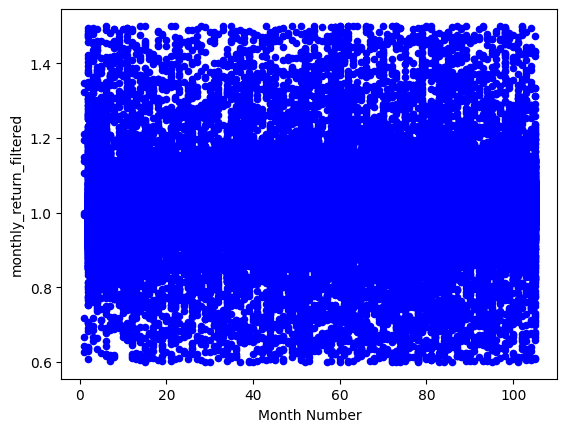

In [6]:
scatter = monthly_returns01.plot.scatter(x = "Month Number", y = "monthly_return_filtered", c='blue', colormap='viridis')
# plt.show()

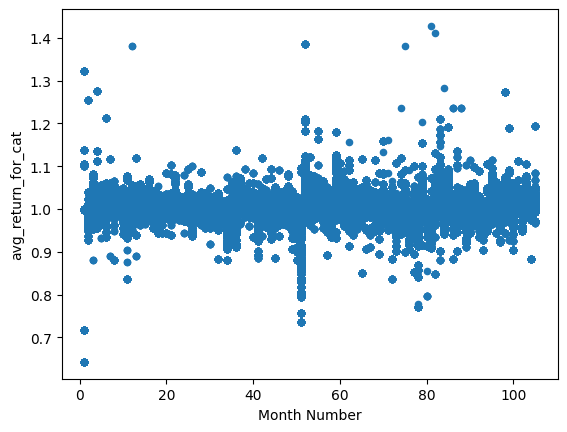

In [7]:
scatter1 = monthly_returns01.plot.scatter(x = "Month Number", y = "avg_return_for_cat")

In [8]:
monthly_returns01["avg_return_for_cat"].describe()

count    453343.000000
mean          1.005746
std           0.032310
min           0.642615
25%           0.991749
50%           1.006225
75%           1.022498
max           1.427705
Name: avg_return_for_cat, dtype: float64

In [9]:

# Register your dataframe, assuming it's already in 'monthly_returns01'
duckdb.register("monthly_returns01", monthly_returns01)

query = """
SELECT
    *,
    PERCENT_RANK() OVER (
       PARTITION BY "CIFSC", "Month Number"
       ORDER BY "monthly_return_filtered"
    ) AS Percite_by_CIFSC
FROM monthly_returns01;
"""

monthly_returns01 = duckdb.query(query).to_df()
print(monthly_returns01.head())


                                           Fund Name Month of Date  \
0                      Dynamic Global Discovery Fund    March 2023   
1              Black Diamond Impact Core Equity Fund    March 2023   
2                           Matco Global Equity Fund    March 2023   
3                       Starlight Global Growth Fund    March 2023   
4  Black Diamond Impact Core Equity Fund (ETF Ser...    March 2023   

   Year of Date  Month Number ETF          Sponsor Sponsor Category  \
0          2023            87   N          Dynamic     Independents   
1          2023            87   N          Purpose     Independents   
2          2023            87   N  Matco Financial     Independents   
3          2023            87   N        Starlight     Independents   
4          2023            87   Y          Purpose     Independents   

           CIFSC                                        Fund Name_1  \
0  Global Equity                      Dynamic Global Discovery Fund   
1  Global 

In [10]:
monthly_returns01.iloc[200500:200550]

,Fund Name,Month of Date,Year of Date,Month Number,ETF,Sponsor,Sponsor Category,CIFSC,Fund Name_1,Net Assets,Gross Sales,Redemptions,monthly_return,monthly_return_filtered,avg_return_for_cat,Percite_by_CIFSC
200500,CI Canadian Bond Corporate Class,April 2023,2023,88,N,CI,Independents,Canadian Fixed Income,CI Canadian Bond Corporate Class,1.076474e+08,0.0,1294300.0,1.010615,1.010615,1.009516,0.598901
200501,CI Canadian Fixed Income Private Pool,April 2023,2023,88,N,CI,Independents,Canadian Fixed Income,CI Canadian Fixed Income Private Pool,6.487140e+06,30630.0,0.0,1.010620,1.010620,1.009516,0.604396
200502,GC One Fixed Income Portfolio,April 2023,2023,88,N,Guardian Capital LP,Independents,Canadian Fixed Income,GC One Fixed Income Portfolio,8.013760e+06,0.0,4190.0,1.010659,1.010659,1.009516,0.609890
200503,United Canadian Fixed Income Corporate Class,April 2023,2023,88,N,CI,Independents,Canadian Fixed Income,United Canadian Fixed Income Corporate Class,9.715294e+08,0.0,1632030.0,1.010730,1.010730,1.009516,0.615385
200504,Guardian Canadian Bond ETF,April 2023,2023,88,Y,Guardian Capital LP,Independents,Canadian Fixed Income,Guardian Canadian Bond ETF,6.576030e+07,1349140.0,1351350.0,1.010754,1.010754,1.009516,0.620879
200505,PEMBROKE CANADIAN BOND FUND,April 2023,2023,88,N,Pembroke,Direct Sellers,Canadian Fixed Income,PEMBROKE CANADIAN BOND FUND,1.986613e+07,0.0,27220.0,1.010768,1.010768,1.009516,0.626374
200506,Leith Wheeler Core Bond Fund,April 2023,2023,88,N,Leith Wheeler,Direct Sellers,Canadian Fixed Income,Leith Wheeler Core Bond Fund,2.737020e+08,0.0,2518630.0,1.010779,1.010779,1.009516,0.631868
200507,CI Global Core Plus Bond Fund,April 2023,2023,88,N,CI,Independents,Canadian Fixed Income,CI Global Core Plus Bond Fund,1.353109e+07,0.0,344300.0,1.010818,1.010818,1.009516,0.637363
200508,Mackenzie Strategic Bond Fund,April 2023,2023,88,N,Mackenzie,Independents,Canadian Fixed Income,Mackenzie Strategic Bond Fund,3.522170e+08,3595000.0,3529000.0,1.010979,1.010979,1.009516,0.642857
200509,NBI Income Fund,April 2023,2023,88,N,National Bank,Banks,Canadian Fixed Income,NBI Income Fund,7.227840e+07,57940.0,445180.0,1.011030,1.011030,1.009516,0.648352
